# Coursera
## Анализ данных: финальный проект
### Жёлтое такси в Нью-Йорке
#### Михалев Антон

# неделя 07: Оформление проекта

# версия для локального запуска
* не смог запустить интерактив
* нужно руками менять значения в ячейках и перезапускать ячейки

## интерактивное демо, содержащее:
* карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени
* временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.


### для визуализации - взяты материалы по ссылке:
* https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/

# ограничения:
* показываются данные - только за июнь 2016 (реальные/прогнозные)
* показываются только регионы, отобранные на предыдущих занятиях (102 шт)

## исходные данные:
* страница со ссылками: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* отдельные файлы:
    * за период с 2009-01 до 2019-06
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-01.csv
        * ...
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
    
    * за период с 2019-07 до 2020-12
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv
        * ...
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2020-12.csv
    

* ссылка на kaggle - https://inclass.kaggle.com/c/yellowtaxi.

In [2]:
# !pip install pandas
# !pip install fsspec
# !pip install matplotlib
# !pip install scipy
# !pip install basemap
# !pip install folium

In [3]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

from scipy import stats

import matplotlib.pyplot as plt

import itertools as it

import datetime as dt

import warnings

import gc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from ipywidgets import widgets

In [5]:
import folium
from folium.plugins import HeatMap

In [6]:
import tqdm

# вспомогательные функции
собраны в начало ноутбука, чтобы было удобнее перезапускать по частям

In [7]:
# тестовые отладочные параметры

__nrows_full = None
__nrows_10 = 10_000

# __nrows_week_01 = __nrows_full
# __nrows_week_01 = __nrows_10

__nrows_pipeline = __nrows_full
# __nrows_pipeline = __nrows_10

# __need_pipeline=True
__need_pipeline=False

# __need_pipeline_2016_05=True
__need_pipeline_2016_05=False
# __need_pipeline_2016_06=True
__need_pipeline_2016_06=False

# __need_save_year=True
__need_save_year=False

__need_load_year=True
# __need_load_year=False

__need_load_more_5=True
# __need_load_more_5=False

# __need_save_region=True
# __need_save_region=False

# __need_load_region=True
# __need_load_region=False

# __nrows_sarimax_fit = __nrows_full
# __nrows_sarimax_fit = 1_000

# __nrows_sarimax_grid = __nrows_full
__nrows_sarimax_grid = 1_000

# __use_1_model = True
__use_1_model = False

__model_rows = __nrows_full
# __model_rows = 5_000



In [8]:
N_pred = 6

K = 23
K_d = 4
stat_len = 24
sum_list = [12, 24, 24*7, 24*7*4] # полдня, сутки, неделю, месяц
near_len = 24

skip_begin = K_d * 24
skip_end = K


In [9]:
new_york_coords = {
    'west': -74.25559, 
    'east': -73.70001, 
    'north': 40.91553, 
    'south': 40.49612, 
}


In [10]:
empire_state_building_region = 1231

In [11]:
# получаем список имен файлов по списку годов/месяцев

s3_amazonaws_com_nyc_tlc_link = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
nyc_tlc_s3_amazonaws_com_link = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
local_folder = '../data/'

def get_names(use_local, dates):
    result = []
    for year, month in dates:
        if use_local:
            result.append(f'{local_folder}yellow_tripdata_{year}-{month:02}.csv')
        else:
            result.append(f'{nyc_tlc_s3_amazonaws_com_link}yellow_tripdata_{year}-{month:02}.csv')
    
    return result
        

In [12]:
# загружаем весь список файлов в один длинный дата-фрейм

def load_data(names, nrows=None, columns=[]):
    result = None
    
    for i, name in enumerate(names):
        print(f'{i+1}/{len(names)}:{name}')
        
        load_df = pd.read_csv(name, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], nrows=nrows)        
        load_df = drop_columns_except(load_df, columns=columns)
        
        if result is None:
            result = load_df
        else:
            result = pd.concat([
                result, 
                load_df
            ])
    return result

In [13]:
# удаляем колонки, за исключением указанных

def drop_columns_except(data, columns):
    data.drop(columns=list(set(data.columns) - set(columns)), inplace=True)
    return data


In [14]:
# чистим данные

def clear_data(data):
    data.drop(data
              [
                (data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) |    
                (data['passenger_count'] <= 0) |    
                (data['trip_distance'] <= 0) |    
                (data['pickup_longitude'] < new_york_coords['west']) | (data['pickup_longitude'] > new_york_coords['east']) |
                (data['pickup_latitude'] < new_york_coords['south']) | (data['pickup_latitude'] > new_york_coords['north'])
              ].index, inplace=True)
    
    return data


In [15]:
# округляем время до часов

def round_time(data):
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor("H")
    return data

In [16]:
# считаем статистику по регионам

def calc_bins(data, bins):
    bins_result = stats.binned_statistic_2d(data['pickup_longitude'], data['pickup_latitude'], 
                                        None, 
                                        statistic='count', 
                                        bins=bins,
                                        expand_binnumbers=True,
                                       )
    data['region'] = (bins_result.binnumber[0] - 1) * 50 + bins_result.binnumber[1]
    
    return data

In [17]:
# считаем групповую статистику по регионам и часам

def calc_aggregated(data):
    result_aggregated = data.groupby(["tpep_pickup_datetime", "region"]).size().to_frame(name='count')
    result_aggregated['passenger_count'] = data.groupby(["tpep_pickup_datetime", "region"])['passenger_count'].sum()
    
    return result_aggregated

In [18]:
# расширяем групповую статистику до полного набора всех возможных значений

def expand_aggregated(data_aggregated, datetime_all, region_all):
    all_product = pd.DataFrame([[x0, y0] for x0 in datetime_all for y0 in region_all], columns=['tpep_pickup_datetime', 'region'])
    all_product.set_index(['tpep_pickup_datetime', 'region'], inplace=True)
    all_product['count_dummy'] = None
    
    data_aggregated_all = all_product.join(data_aggregated)
    
    data_aggregated_all.drop(columns=['count_dummy'], inplace=True)
    
    data_aggregated_all.fillna(0, inplace=True)
    
    data_aggregated_all.reset_index(inplace=True)

    return data_aggregated_all

In [19]:
# полный цикл обработки для заданного списка файлов

def full_pipeline(names, nrows, bins, data_regions):
    print('(-/6) pipeline begin...')

    result = load_data(names, nrows=nrows, columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'trip_distance'])
    print('(1/6) load_data end...')

    result = clear_data(result)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count'])
    print('(2/6) clear_data end...')
    
    result = round_time(result)
    print('(3/6) round_time end...')
    
    result = calc_bins(result, bins=bins)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'region', 'passenger_count'])
    print('(4/6) calc_bins end...')
    
    result_aggregated = calc_aggregated(result)
    print('(5/6) calc_aggregated end...')
        
    result_aggregated_expanded = expand_aggregated(result_aggregated, result_aggregated.index.unique(level='tpep_pickup_datetime'), data_regions['region'].unique())
    result_aggregated_expanded = drop_columns_except(result_aggregated_expanded, ['tpep_pickup_datetime', 'region', 'count', 'passenger_count'])
    print('(6/6) expand_aggregated end...')
    
    print('(-/-) pipeline end...')
    return result_aggregated_expanded


In [20]:
def calc_date_columns(df, column_prefix=None):
    date_columns = []
    
    column_name = 'date_year'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.year
    date_columns.append(column_name)

    column_name = 'date_month'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.month
    date_columns.append(column_name)

    column_name = 'date_day'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.day
    date_columns.append(column_name)

    column_name = 'date_dayofweek'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.dayofweek
    date_columns.append(column_name)

    column_name = 'date_hour'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.hour
    date_columns.append(column_name)
    
    return df, date_columns


In [21]:
from sklearn.preprocessing import OneHotEncoder

def calc_one_hot_fit_transform(df, column_list):    
    one_hot_columns = []
    one_hot_encoders = {}

    for column_name_original in column_list:
        one_hot_encoders[column_name_original] = OneHotEncoder(handle_unknown='ignore')

        one_hot_encoders[column_name_original].fit(df[column_name_original].values.reshape(-1, 1))
        one_hot_result = one_hot_encoders[column_name_original].transform(df[column_name_original].values.reshape(-1, 1))
        
        for i in range(one_hot_result.shape[1]):
            column_name_one_hot = f'{column_name_original}_{i}'
            df[column_name_one_hot] = one_hot_result[:, i].toarray()
            
            one_hot_columns.append(column_name_one_hot)
        
    return df, one_hot_columns, one_hot_encoders


def calc_one_hot_transform(df, column_list, one_hot_encoders):    
    one_hot_columns = []

    for column_name_original in column_list:
        one_hot_result = one_hot_encoders[column_name_original].transform(df[column_name_original].values.reshape(-1, 1))
        
        for i in range(one_hot_result.shape[1]):
            column_name_one_hot = f'{column_name_original}_{i}'
            df[column_name_one_hot] = one_hot_result[:, i].toarray()
            
            one_hot_columns.append(column_name_one_hot)
        
    return df, one_hot_columns



In [22]:
def add_t_sin_cos(df, k=15, start_t=0, column_prefix=None):
    period_list = [1, 7, 12, 24, 24*7, 24*7*4, 365]
    
    column_t = 't'
    if column_prefix is not None:
        column_t = (column_prefix, column_t)
    
    harmonic_columns = [column_t]
    
    t = np.array(range(start_t, start_t + len(df)))
    df[column_t] = t    
    
    for period in period_list:
        for i in range(1, k+1):
            column_name = f'sin_{i}_{period}'
            if column_prefix is not None:
                column_name = (column_prefix, column_name)
            harmonic_columns.append(column_name)
            df[column_name] = np.sin(df[column_t] * 2 * np.pi * i / period)

            column_name = f'cos_{i}_{period}'
            if column_prefix is not None:
                column_name = (column_prefix, column_name)
            harmonic_columns.append(column_name)
            df[column_name] = np.cos(df[column_t] * 2 * np.pi * i / period)
        
    return df, harmonic_columns


In [23]:
def calc_lags(df, pivot_regions, K, K_d, N_pred, stat_len, sum_list=[]):
    for region_current in tqdm.tqdm(pivot_regions):
        columns_lag_plus = []
        columns_lag_minus = []
        columns_lag_sum = []
        columns_lag_stat = []

        column_name_count = (region_current, f'count')

        for i in range(1, N_pred + 1):
            column_name_lag = f'lag_plus_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_plus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(-i)

        for i in range(1, K + 1):
            column_name_lag = f'lag_minus_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_minus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(i)

        for i in range(1, K_d + 1):
            column_name_lag = f'lag_minus_{i * 24}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_minus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(i * 24)

        for i in sum_list:
            column_name_lag = f'lag_sum_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_sum.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(i).sum()
            df_pivot[column_name_lag_full].fillna(value=df_pivot[column_name_count].cumsum(), inplace=True)

        column_name_lag = f'lag_mean_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).mean()
        
        column_name_lag = f'lag_median_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).median()
        
        column_name_lag = f'lag_std_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).std()
                
    return df, columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat


In [24]:
def add_arima_lags_plus(df, df_arima, lags_count, region_n, column_prefix):
    columns_lag_plus = []
    
    for i in range(1, lags_count + 1):
        column_name_lag = f'{column_prefix}_lag_plus_{i}'
        column_name_lag_full = (region_n, column_name_lag)
        columns_lag_plus.append(column_name_lag)
        df[column_name_lag_full] = df_arima.shift(-i)
        
    return df, columns_lag_plus
        
        
def add_arima(df, df_arima, pivot_regions):
    arima_columns = []

    new_column_name_linear_sin_cos_predict = 'linear_sin_cos_predict'
    new_column_name_sarimax = 'sarimax'
    new_column_name_full_predict = 'full_predict'
    
    arima_columns.append(new_column_name_linear_sin_cos_predict)
    arima_columns.append(new_column_name_sarimax)
    arima_columns.append(new_column_name_full_predict)

    for region_current in tqdm.tqdm(pivot_regions):
        old_column_name_linear_sin_cos_predict = f'region_{region_current}_linear_sin_cos_predict'
        df[(region_current, new_column_name_linear_sin_cos_predict)] = df_arima[old_column_name_linear_sin_cos_predict]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_linear_sin_cos_predict], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_linear_sin_cos_predict)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)

        old_column_name_sarimax = f'region_{region_current}_sarimax'
        df[(region_current, new_column_name_sarimax)] = df_arima[old_column_name_sarimax]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_sarimax], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_sarimax)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)

        old_column_name_full_predict = f'region_{region_current}_full_predict'
        df[(region_current, new_column_name_full_predict)] = df_arima[old_column_name_full_predict]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_full_predict], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_full_predict)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)
        
    return df, arima_columns


In [25]:
def calc_holiday_columns(df, start, end, column_prefix=None):
    holiday_columns = []
    
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=start, end=end) 

    column_name = 'holiday'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = np.isin(df.index.date, holidays.date).astype(int)
    holiday_columns.append(column_name)

    column_name = 'holiday_minus_1'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = np.isin(df.index.date, holidays.date - dt.timedelta(days = - 1)).astype(int)
    holiday_columns.append(column_name)

    column_name = 'holiday_plus_1'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = np.isin(df.index.date, holidays.date - dt.timedelta(days = + 1)).astype(int)
    holiday_columns.append(column_name)

    return df, holiday_columns


In [26]:
def get_regions_near(region_n, row_count, col_count):
    all_count = row_count * col_count
    result = []
    
    if (region_n + 1) < all_count:
        result.append(region_n + 1)
        
    if (region_n + col_count) < all_count:
        result.append(region_n + col_count)

    if (region_n + col_count - 1) < all_count:
        result.append(region_n + col_count - 1)

    if (region_n + col_count + 1) < all_count:
        result.append(region_n + col_count + 1)

    if (region_n - 1) >= 0:
        result.append(region_n - 1)
        
    if (region_n - col_count) >= 0:
        result.append(region_n - col_count)

    if (region_n - col_count - 1) >= 0:
        result.append(region_n - col_count - 1)

    if (region_n - col_count + 1) >= 0:
        result.append(region_n - col_count + 1)
    
    return result

In [27]:
def calc_lags_near(df, pivot_regions, row_count, col_count, near_len, sum_list=[]):
    columns_lag_near = []
    
    for region_current in tqdm.tqdm(pivot_regions):
        columns_near = [(region_near, f'count') for region_near in np.unique(get_regions_near(region_current, row_count, col_count))]

        for lag_i in range(0, near_len + 1):
            for near_i in range(len(columns_near)):
                column_name_lag = f'lag_near_{near_i+1}_minus_{lag_i}'
                column_name_lag_full = (region_current, column_name_lag)
                if column_name_lag not in columns_lag_near:
                    columns_lag_near.append(column_name_lag)

                df_pivot[column_name_lag_full] = df_pivot[columns_near[near_i]].shift(lag_i)

            column_name_lag = f'lag_near_sum_minus_{lag_i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)

            df_pivot[column_name_lag_full] = df_pivot[columns_near].shift(lag_i).sum(axis=1)
                
        for i in sum_list:
            column_name_lag_data = (region_current, f'lag_near_sum_minus_0')

            column_name_lag = f'lag_near_sum_sum_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).sum()
            df_pivot[column_name_lag_full].fillna(value=df_pivot[column_name_lag_data].cumsum(), inplace=True)

            column_name_lag = f'lag_near_sum_mean_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).mean()

            column_name_lag = f'lag_near_sum_median_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).median()

            column_name_lag = f'lag_near_sum_std_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).std()

    return df, columns_lag_near


In [28]:
def unpivot_table(df, common_columns, pivot_regions):
    result = None


    for region_current in tqdm.tqdm(pivot_regions):
        df_new = df[common_columns].copy()
        
        pivot_region_columns = [column for column in df.columns if column[0] == region_current]
        unpivot_region_columns = [('region', column[1]) for column in df.columns if column[0] == region_current]
        
        df_new[('region', 'id')] = region_current
        df_new[unpivot_region_columns] = df[pivot_region_columns]
        
        if result is None:
            result = df_new
        else:
            result = result.append(df_new)
            
    unpivot_region_columns_dict = {
        'id': ('region', 'id'),
        'count': ('region', 'count'),               
        'lags': [c for c in unpivot_region_columns if c != ('region', 'count')],
        'all': [('region', 'id')] + unpivot_region_columns,
    }
            
    return result, common_columns, unpivot_region_columns_dict


In [29]:
def create_submission(result):
    df = []
    for region_n, region_result in result.items():
        for history_end, history_result in region_result.items():
            submission_date_time = datetime.datetime.strftime(history_end, '%Y-%m-%d_%#H')
            for pred_n, pred_value in enumerate(history_result):
                df.append([f'{region_n}_{submission_date_time}_{pred_n + 1}', pred_value]) 

    return pd.DataFrame(df, columns=['id', 'y'])
                           

In [30]:
# https://www.kaggle.com/wittmannf/aula-2-awari

## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


## регионы

In [31]:
data_regions = pd.read_csv(local_folder + 'regions.csv', sep=';')
data_regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [32]:
# data_regions['west'].value_counts()
# data_regions['east'].value_counts()
# data_regions['south'].value_counts()
# data_regions['north'].value_counts()

In [33]:
# data_regions['west'].unique()
# data_regions['east'].unique()
# data_regions['south'].unique()
# data_regions['north'].unique()

In [34]:
len(data_regions['west'].unique()), len(data_regions['east'].unique()), len(data_regions['south'].unique()), len(data_regions['north'].unique())

(50, 50, 50, 50)

In [35]:
set(data_regions['west'].unique()) - set(data_regions['east'].unique())

{-74.25559}

In [36]:
set(data_regions['south'].unique()) - set(data_regions['north'].unique())

{40.49612}

In [37]:
x_bins = data_regions['west'].append(data_regions['east']).unique()
y_bins = data_regions['south'].append(data_regions['north']).unique()

len(x_bins), len(y_bins)

(51, 51)

### найдем ячейки "которые были отобраны на второй неделе":
* "отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся"
* правильный ответ: 102

In [38]:
if __need_load_more_5:
    data_2016_05_more_5 = pd.read_csv(f'data_2016_05_more_5.csv')
    data_2016_05_more_5

In [39]:
print(data_2016_05_more_5.info())
data_2016_05_more_5 = reduce_mem_usage(data_2016_05_more_5)
print(data_2016_05_more_5.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  102 non-null    int64  
 1   month   102 non-null    object 
 2   count   102 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ KB
None
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 62.8%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   region  102 non-null    int16   
 1   month   102 non-null    category
 2   count   102 non-null    float32 
dtypes: category(1), float32(1), int16(1)
memory usage: 958.0 bytes
None


In [40]:
len(set(data_2016_05_more_5['region']))

102

In [41]:
region_102 = pd.Series(data_2016_05_more_5['region'].unique(), name='region')
region_102

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: region, Length: 102, dtype: int16

## грузим реальные данные за июнь 2016

In [42]:
%%time

test_period = '2016-06'
dates = [(2016, 6)]

if __need_pipeline_2016_06:
    data_2016_06 = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_2016_06.to_csv(f'data_{test_period}.csv', index=False)
else:
    data_2016_06 = pd.read_csv(f'data_{test_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
data_2016_06.set_index('tpep_pickup_datetime', inplace=True)

data_2016_06

# Wall time: 2min 5s

Wall time: 2.9 s


,region,count,passenger_count
tpep_pickup_datetime,,,
2016-06-01 00:00:00,1,0.0,0.0
2016-06-01 00:00:00,2,0.0,0.0
2016-06-01 00:00:00,3,0.0,0.0
2016-06-01 00:00:00,4,0.0,0.0
2016-06-01 00:00:00,5,0.0,0.0
...,...,...,...
2016-06-30 23:00:00,2496,0.0,0.0
2016-06-30 23:00:00,2497,0.0,0.0
2016-06-30 23:00:00,2498,0.0,0.0


In [43]:
len(data_2016_06['region'].unique()), data_2016_06['region'].unique()

(2500, array([   1,    2,    3, ..., 2498, 2499, 2500], dtype=int64))

## грузим сохраненные прогнозы

In [44]:
df_val_result_06_save = pd.read_csv('df_val_result_06_save.csv',
                               parse_dates=['tpep_pickup_datetime'],
                              )
df_val_result_06_save.set_index('tpep_pickup_datetime', inplace=True)

df_val_result_06_save


,region,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6
tpep_pickup_datetime,,,,,,,
2016-05-31 23:00:00,1075,17.619010,8.224202,2.018704,0.000000,2.903345,8.393534
2016-06-01 00:00:00,1075,9.673828,0.000000,0.000000,0.000000,4.033983,19.910736
2016-06-01 01:00:00,1075,4.171190,0.000000,2.490225,6.892937,17.122822,41.362362
2016-06-01 02:00:00,1075,0.000000,2.737076,7.687000,17.118067,46.756940,65.408770
2016-06-01 03:00:00,1075,2.934197,7.270452,16.897337,45.893880,72.004260,56.914963
...,...,...,...,...,...,...,...
2016-06-30 13:00:00,2168,34.329224,72.508090,64.300920,57.213905,64.762170,67.217230
2016-06-30 14:00:00,2168,62.413643,64.606300,61.565964,69.959040,85.483345,82.319150
2016-06-30 15:00:00,2168,36.587746,52.555923,67.595420,85.119090,99.037000,88.867810


### выравниваем длину рельных и прогнозных данных

In [45]:
df_real_2016_06 = data_2016_06

df_real_2016_06 = df_real_2016_06[df_real_2016_06['region'].isin(region_102)][['region', 'count']]
df_real_2016_06 = df_real_2016_06[df_real_2016_06.index <= '2016-06-30 17:00:00']

df_real_2016_06

,region,count
tpep_pickup_datetime,,
2016-06-01 00:00:00,1075,26.0
2016-06-01 00:00:00,1076,30.0
2016-06-01 00:00:00,1077,19.0
2016-06-01 00:00:00,1125,39.0
2016-06-01 00:00:00,1126,71.0
...,...,...
2016-06-30 17:00:00,2068,189.0
2016-06-30 17:00:00,2069,15.0
2016-06-30 17:00:00,2118,210.0


In [46]:
df_pred_2016_06 = df_val_result_06_save[df_val_result_06_save.index >= '2016-06-01 00:00:00'][['region', 'prediction_1']].copy()
df_pred_2016_06.columns = ['region', 'count']
df_pred_2016_06


,region,count
tpep_pickup_datetime,,
2016-06-01 00:00:00,1075,9.673828
2016-06-01 01:00:00,1075,4.171190
2016-06-01 02:00:00,1075,0.000000
2016-06-01 03:00:00,1075,2.934197
2016-06-01 04:00:00,1075,6.061596
...,...,...
2016-06-30 13:00:00,2168,34.329224
2016-06-30 14:00:00,2168,62.413643
2016-06-30 15:00:00,2168,36.587746


In [47]:
len(df_real_2016_06), len(df_pred_2016_06)

(72828, 72828)

In [48]:
df_real_2016_06 = reduce_mem_usage(df_real_2016_06)


Memory usage of dataframe is 1.67 MB
Memory usage after optimization is: 0.97 MB
Decreased by 41.7%


In [49]:
df_pred_2016_06 = reduce_mem_usage(df_pred_2016_06)


Memory usage of dataframe is 1.67 MB
Memory usage after optimization is: 0.97 MB
Decreased by 41.7%


# карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени

### пробовал запустить:
* ipywidgets
* holoviews

In [50]:
from ipywidgets import *

def f(x):
    print(x)
    
widgets.interact(f, x=10)

10


<function __main__.f(x)>

In [51]:
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets

text = widgets.Text(description="Domain to ping", width=200)
display(text);

d:\_Work\обучение\Coursera\_env\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


Text(value='', description='Domain to ping')

In [52]:
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

In [53]:
# import pandas as pd
# import holoviews as hv
# from holoviews import opts, dim
# hv.extension('bokeh')

## интерактива не получилось :(
* никак не удалось запустить ни один из рекомендованных инструментов
* для выбора момента времени или региона - нужно в ячейках ниже - задать руками дату и время, либо номер региона

In [54]:
def calc_polygons(data_regions):
    result = []

    for n_region in region_102:
        region_i = data_regions[data_regions['region'] == n_region]

        result.append(
            [
                (region_i['north'].values[0], region_i['west'].values[0]), 
                (region_i['north'].values[0], region_i['east'].values[0]), 
                (region_i['south'].values[0], region_i['east'].values[0]), 
                (region_i['south'].values[0], region_i['west'].values[0]), 
                (region_i['north'].values[0], region_i['west'].values[0]), 
            ],
        )
    
    return result
    

In [55]:
polygon_regions_all = calc_polygons(data_regions)    
polygon_regions_all[:5]

[[(40.705825, -74.0222464),
  (40.705825, -74.0111348),
  (40.6974368, -74.0111348),
  (40.6974368, -74.0222464),
  (40.705825, -74.0222464)],
 [(40.7142132, -74.0222464),
  (40.7142132, -74.0111348),
  (40.705825, -74.0111348),
  (40.705825, -74.0222464),
  (40.7142132, -74.0222464)],
 [(40.7226014, -74.0222464),
  (40.7226014, -74.0111348),
  (40.7142132, -74.0111348),
  (40.7142132, -74.0222464),
  (40.7226014, -74.0222464)],
 [(40.705825, -74.0111348),
  (40.705825, -74.0000232),
  (40.6974368, -74.0000232),
  (40.6974368, -74.0111348),
  (40.705825, -74.0111348)],
 [(40.7142132, -74.0111348),
  (40.7142132, -74.0000232),
  (40.705825, -74.0000232),
  (40.705825, -74.0111348),
  (40.7142132, -74.0111348)]]

In [56]:
def calc_data(data_source, date_time):
    result = []

    for index_current, row_current in data_source[data_source.index == date_time].iterrows():
        n_region = row_current['region']
        c_region = row_current['count']

        region_i = data_regions[data_regions['region'] == n_region]
        x_region = (region_i['west'] + region_i['east']) / 2
        y_region = (region_i['south'] + region_i['north']) / 2

        result.append([y_region.values[0], x_region.values[0], c_region])
        
    return np.array(result)


## в этой ячейке руками надо менять дату

In [57]:
date_time = '2016-06-01 00:00:00'

In [58]:
def show_map(data, polygon_regions_all):
    map_object = folium.Map(location=[(new_york_coords['south'] + new_york_coords['north']) / 2, (new_york_coords['west'] + new_york_coords['east']) / 2], zoom_start=11)

    HeatMap(data[:, 0:3]).add_to(map_object)

    for polugon_i, polygon_region in enumerate(polygon_regions_all):
        folium.PolyLine(polygon_region, color='black', weight=0.2).add_to(map_object)

    return map_object


In [59]:
data_real = calc_data(data_source=df_real_2016_06, date_time=date_time)
map_object = show_map(data_real, polygon_regions_all)
map_object

In [60]:
data_pred = calc_data(data_source=df_pred_2016_06, date_time=date_time)
map_object = show_map(data_pred, polygon_regions_all)
map_object

# временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.

## в этой ячейке руками надо менять номер региона

In [61]:
region_n = 1075

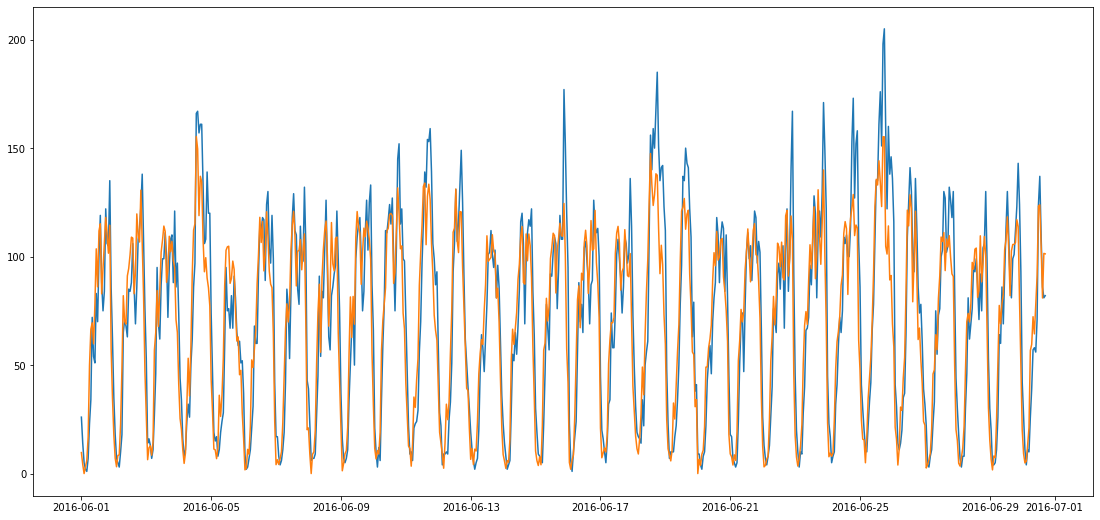

In [62]:
fig, ax = subplots(1, 1, figsize=(19, 9))

ax.plot(df_real_2016_06[df_real_2016_06['region'] == region_n]['count'])
ax.plot(df_pred_2016_06[df_pred_2016_06['region'] == region_n]['count'])